## Introduction<a id='introduction'></a>
**Purpose:** \
To develop a pre-screening model that predicts the probability with over 90% of a patient having late stage NASH using only readily avilable patient data

**Context:** \
Nonalcoholic steatohepatitis (NASH) affects approximately 5% of US adults and 8% of the global population. Late stages of NASH include cirrhosis of the liver, which is a major risk factor in developing cancer. Biotech companies, including Akero Therapeutics, Viking Therapeutics, Pfizer, and Novo Nordisk, have begun developing theapies for treating late stages of NASH. To be elligible for such therapies, patients must receive an MRI, which can take 2 hours per patient. With such a large patient population, pre-screening for eligiblity can expand access and can help patients in need gain access more quickly. 

**Data:** \
The data used to train this model comes from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset), which originates from the Mayo Clinic. Additional data from [Synthea](https://console.cloud.google.com/) could also be of interest.

**Summary of data wrangling and eda:** \
Some significant changes were made to the raw data and are listed below:
* Removed NaN stages
* Removed either non-informative or difficult-to-obtain columns
* Removed outliers
* Split according to frequency of NaNs

Plan to train using both male and female patients, although there are few enough male patients (25 male vs 270 female) that could also remove.

```ALBI, APRI, FIB-4``` are the most promising variables for predicting staging, although none, individually, clearly separate staging. 

**Outcomes of this notebook:** \
Many classification algorithms were trained and evaluated with a logistic regression classifier striking the best balance of simplicity and ease of use. Compared to pre-existing screening tests for liver disease, the ALBI, APRI, and FIB-4 scores, a logistic regression classifier had a 15% relative increase in accuracy for detecting advance fibrosis and a 16% relative increase in accuracy for detecting cirrhosis. 

## Contents<a id='contents'></a>
* [Introduction](#introduction)
* [Contents](#contents)
* [Objectives](#objectives)
* [Summary](#summary)
* [Preprocessing and Setup](#preprocessing_and_setup)
* [Benchmarks](#benchmarks)
    * [Random Model](#random_model)
    * [Mean Model](#mean_model)
    * [ALBI Model](#albi_model)
        * [Predicting Advanced Fibrosis](#predicting_advanced_fibrosis_albi)
        * [Predicted Cirrhosis](#predicting_cirrhosis_albi)
    * [APRI Model](#apri_model)
        * [Predicting Advanced Fibrosis](#predicting_advanced_fibrosis_apri)
        * [Predicting Cirrhosis](#predicint_cirrhosis_apri)
    * [FIB-4 Model](#fib-4_model)
        * [Predicting Advanced Fibrosis](#predicting_advanced_fibrosis_fib-4)
        * [Predicting Cirrhosis](#predicting_cirrhosis_fib-4)
* [K-Nearest Neighbors](#k-nearest_neighbors)
* [Random Forest](#random_forest)
* [Logistic Regression](#logistic_regression)
* [Naive Bayes](#naive_bayes)
* [Support Vector Machine](#support_vector_machine)
* [Gradient Boosting](#gradient_boosting)
* [Feedforward NN](#feedforward_nn)
    * [Predicting Advanced Fibrosis](#predicting_advanced_fibrosis_fnn)
    * [Predicting Cirrhosis](#predicing_cirrhosis_fnn)

## Objectives<a id='objectives'></a>
1. Identify goals for success
2. Identify classification algorithm that performs best and meets real-world constraints

## Summary<a id='summary'></a>
The objectives of this notebook are
1. Identify goals for success
2. Identify classification algorithm that performs best and meets real-world constraints

The metric for success is to predict advanced fibrosis or cirrhosis with greater accuracy than pre-existing serum tests, which are the APRI, ALBI, and FIB-4 scores. As a base case, a random model, one which randomly guesses a patient's condition based on population statistics, was also evaluated. Sensitivity, specificity, accuracy, and F1-score are shown below for each model.

|                     |            | **Sensitivity** | **Specificity** | **Precision** | **F1-Score** | **Accuracy** |
|---------------------|------------|-----------------|-----------------|---------------|--------------|--------------|
|**Advanced Fibrosis**| **Random** | 0.265 | 0.735 | 0.265 | 0.265 | 0.704 |
|                     | **ALBI**   | 0.653 | 0.704 | 0.860 | 0.742 | 0.667 |
|                     | **APRI**   | 0.649 | 0.654 | 0.849 | 0.732 | 0.65  |
|                     | **FIB-4**  | 0.556 | 0.642 | 0.812 | 0.660 | 0.578 |
|                     | **Log Regression** | 0.430 | 0.787 | 0.499 | 0.447 | **0.728** |
|                     | **FNN**    | 0.357 | 0.938 | 0.802 | 0.863 | 0.784 |
|**Cirrhosis**        | **Random** | 0.343 | 0.657 | 0.343 | 0.343 | 0.75  |
|                     | **ALBI**   | 0.810 | 0.592 | 0.509 | 0.625 | 0.667 |
|                     | **APRI**   | 0.638 | 0.657 | 0.493 | 0.556 | 0.65  |
|                     | **FIB-4**  | 0.59  | 0.687 | 0.496 | 0.539 | 0.654 |
|                     | **Log Regression** | 0.683 | 0.710 | 0.649 | 0.659 | **0.762** |
|                     | **FNN**    | 0.510 | 0.909 | 0.694 | 0.837 | 0.771 |

Many models, including K-Nearest Neighbors, Random Forest, Logistic Regression, Naive Bayes, Support Vector Machines, Gradient Boosting, and Feedforward Neural Networks, were trained and evaluated. Ultimately, a simple **logistic regression classifier stuck the best balance of performance, with a 15% relative increase in accuracy for detecting advance fibrosis and a 16% relative increase in accuracy for detecting cirrhosis compared to ALBI, APRI, FIB-4 scoring, and ease of use.** Compared to the best performing model, a feedforward neural network, the logistic regression classifier was only 4.6% behind in detecting advanced fibrosis and only 0.9% behind detecting cirrhosis. With neural networks being difficult to share and update, it is not recommended that neural networks be used to prescreen for liver disease. 

It is worth noting that disease staging was not easily separable which led to relatively poor performance. The best accuracy, which came from a feedforward neural network, was only 78.4% and 77.1% for detecting advanced fibrosis and cirrhosis, respectively. I also tried training using less features to reduce noise, but doing so did not significantly improve performance.

## Preprocessing and Setup<a id='preprocessing_and_setup'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import eda_functions as eda_f
import warnings
np.random.seed(42)

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [3]:
class OneHotNan(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        X_oh = ohe.fit_transform(X)
        
        if True not in pd.isnull(ohe.categories_):
            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
        if True in pd.isnull(ohe.categories_):
            for ind, val in enumerate(ohe.categories_[0]):
                if pd.isnull(val):
                    nan_col = ind
            nan_rows = [ind for ind, val in enumerate(X_oh[:, nan_col]) if val > 0]

            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
            X_oh.loc[nan_rows,:] = pd.NA
            X_oh = X_oh.drop(columns=ohe.categories_[0][nan_col])
        return X_oh

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        OH_NaN = OneHotNan()

        X_cat = pd.DataFrame()
        for cat_col in self.columns:
            df = OH_NaN.fit_transform(X[[cat_col]])

            new_cols = [cat_col+'_'+s for s in df.columns]
            X_cat = pd.concat([X_cat, df.rename(columns=dict(zip(df.columns, new_cols)))], axis=1)
        return X_cat

class BinCategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        X_bin = pd.DataFrame()
        for col in self.columns:
            X_bin = pd.concat([X_bin, X[[col]].replace(('Y','N'), (1,0))], axis=1)
        return X_bin

class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scaler = StandardScaler()
        X_num = pd.DataFrame(scaler.fit_transform(X[self.columns]), columns=self.columns)
        return X_num

In [4]:
def preprocess(df):
    feature_union = FeatureUnion([
        ('bin_trans', BinCategoricalTransformer(columns=['Hepatomegaly', 'Spiders'])),
        ('cat_trans', CategoricalTransformer(columns=['Drug', 'Edema', 'Sex'])),
        ('num_trans', NumericalTransformer(columns=['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
                                                    'Alk_Phos', 'SGOT', 'Triglycerides', 'Platelets',
                                                    'Prothrombin', 'ALBI', 'APRI', 'FIB-4']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('scaler', StandardScaler()),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['bin_trans', 'cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    df_imputed['Stage'] = df['Stage']
    
    return df_imputed

In [5]:
def preprocess_pca(df):
    '''
    Preprocesses feature space using PCA to remove noise, knn_impute to remove nans, and standardscaler
    Do not feed in target space
    '''
    feature_union = FeatureUnion([
        ('bin_trans', BinCategoricalTransformer(columns=['Hepatomegaly', 'Spiders'])),
        ('cat_trans', CategoricalTransformer(columns=['Drug', 'Edema', 'Sex'])),
        ('num_trans', NumericalTransformer(columns=['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
                                                    'Alk_Phos', 'SGOT', 'Triglycerides', 'Platelets',
                                                    'Prothrombin', 'ALBI', 'APRI', 'FIB-4']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('scaler', StandardScaler()),
        ('knn_impute', KNNImputer()),
        ('pca', PCA(n_components=0.95, svd_solver='full'))
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)
    
    return df_imputed

In [6]:
def calc_2class_scores(true, pred):
    c_matrix = confusion_matrix(true, pred)
    my_score = {}
    my_score['recall'] = round(c_matrix[0,0]/(c_matrix[0,0] + c_matrix[0,1] + 1e-9), 3)
    my_score['specificity'] = round(c_matrix[1,1]/(c_matrix[1,1] + c_matrix[1,0] + 1e-9), 3)
    my_score['precision'] = round(c_matrix[0,0]/(c_matrix[0,0] + c_matrix[1,0] + 1e-9), 3)
    my_score['f1-score'] = round(2*my_score['precision']*my_score['recall']/(my_score['precision']+my_score['recall']), 3)
    my_score['accuracy'] = round((c_matrix[0,0]+c_matrix[1,1])/sum(sum(c_matrix)), 3)
    my_score['support_pos'] = sum(c_matrix[0,:])
    my_score['support_neg'] = sum(c_matrix[1,:])
    return my_score

In [7]:
def calc_3class_scores(true, pred):
    '''
    Calculates precision, recall, f1-score, specificity, accuracy, and support
    for classification of 3 classes given the predicted classes and the true classes
    Returns as dictionary of dictionaries
    '''
    classifications = sorted(list(set(np.array(true).flatten()).union(set(np.array(pred).flatten()))))

    c_matrix = confusion_matrix(true, pred, labels=classifications)
    my_score = {}
    for ind, my_class in enumerate(classifications):
        tn = sum(c_matrix.diagonal()) - c_matrix[ind,ind]

        precision = c_matrix[ind, ind]/sum(c_matrix[:,ind], 1e-9)
        recall = c_matrix[ind, ind]/sum(c_matrix[ind,:], 1e-9)
        f1 = 2*precision*recall/(precision+recall+1e-9)
        specificity = tn/(tn+sum(c_matrix[:,ind])-c_matrix[ind,ind]+1e-9)
        accuracy = (sum(sum(c_matrix)) - sum(c_matrix[ind,:]) - sum(c_matrix[:,ind]) + 2*c_matrix[ind,ind])/sum(sum(c_matrix), 1e-9)
        support = sum(c_matrix[ind,:])

        my_score[my_class] = {'recall':recall, 'specificity':specificity, 'precision':precision,
                               'f1-score':f1, 'accuracy':accuracy, 'support':support}

    return my_score

In [8]:
def bs_model(X, Y, model, m=10000, p1=2.5, p2=97.5):
    '''
    X, Y should be preprocessed and directly ready for splitting and training
    Uses calc_class_scores() function
    '''
    # grabbing shape, index, and columns of score
    my_df = pd.DataFrame(calc_3class_scores(Y, Y)).T
    a,b = my_df.shape
    cols = my_df.columns
    index = pd.MultiIndex.from_tuples(list(itertools.product(my_df.index, ['mean', str(p2-p1)+'% CI'])))
    
    # resampling data m times
    bs_scores = np.empty([m, a, b])
    for i in range(m):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        bs_scores[i] = np.array([list(val.values()) for val in calc_3class_scores(y_test, y_pred).values()])
    
    # calculating statistics from bs data
    means = np.mean(bs_scores, axis=0).round(3)
    percentiles = np.percentile(bs_scores, [p1, p2], axis=0).round(3)

    # reshaping percentiles so that last index holds the confidence interval
    a, b = my_df.shape
    ci = np.empty([a,b,2])
    for i in range(a):
        for j in range(b):
            ci[i,j] = [percentiles[0,i,j], percentiles[1,i,j]]

    # reshaping means and percentiles
    data = []
    for i in range(a):
        data.append(means[i])
        data.append(ci[i])

    return pd.DataFrame(data, index=index, columns=cols)

In [9]:
def plot_train_test(cv_results):
    plt.figure(figsize=(8,3))
    plt.plot(cv_results['mean_test_score'], '.-', color='C0', label='test score')
    # plt.twinx()
    plt.plot(cv_results['mean_train_score'], '.-', color='C1', label='train score')
    plt.twinx()
    plt.plot(cv_results['mean_train_score']-cv_results['mean_test_score'], '.--', color='C2', label='difference')
    plt.ylabel('train - test', color='C2')

In [10]:
# Loading data
female_lownan = eda_f.add_apri_fib4_albi(pd.read_csv('../data/interim/female_low_nans.csv', index_col=0))
male_lownan = eda_f.add_apri_fib4_albi(pd.read_csv('../data/interim/male_low_nans.csv', index_col=0))

In [11]:
df = pd.concat([female_lownan, male_lownan], ignore_index=True)
preprocess_df = preprocess(df)
X, Y = (preprocess_df.drop(columns='Stage'), preprocess_df[['Stage']])

In [12]:
preprocess_df.head(3)

,Hepatomegaly,Spiders,Drug_D-penicillamine,Drug_Placebo,Edema_N,Edema_S,Edema_Y,Sex_F,Sex_M,Age,...,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,ALBI,APRI,FIB-4,Stage
0,0.987012,1.599418,0.980581,-0.980581,-2.377430,-0.317363,4.00,0.365148,-0.365148,0.826878,...,0.811787,-0.118208,0.332424,0.903557,-0.745655,1.689741,2.480920,0.329675,0.255957,4
1,0.987012,1.599418,0.980581,-0.980581,0.420622,-0.317363,-0.25,0.365148,-0.365148,0.608446,...,-0.524798,2.533758,-0.132820,-0.602198,-0.422514,-0.092459,-0.826428,-0.108790,-0.479904,3
2,0.987012,1.599418,0.980581,-0.980581,-2.377430,3.150964,-0.25,0.365148,-0.365148,0.447782,...,-0.393760,1.939065,-1.140056,-0.530495,-0.818622,-0.426621,0.749456,-0.485251,-0.591925,4


## Benchmarks<a id='benchmarks'></a>

Will benchmark against 5 different models, with those being
1. Random Model
2. Mean Model
3. ALBI model
4. APRI model
5. FIB-4 model

Random Model randomly guesses stage knowing the distribution of stages from the dataset. (i.e. if 50% of patients are classified as stage F3, then it would guess F3 50% of the time)

Mean model will compute the mean values for each column grouped by stage. Model will then predict staging based on cosine similarity.

ALBI, APRI, and FIB-4 model will come from references.

### Random Model<a id='random_model'></a>
**Result:**
|                |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** | **support** |
|----------------|---------|-----------------|-----------------|---------------|--------------|--------------|-------------|
|**Random Model**| **1/2** | 0.265 | 0.735 | 0.265 | 0.265 | 0.704 | 81 |
|                | **3**   | 0.392 | 0.608 | 0.392 | 0.392 | 0.601 | 120 |
|                | **4**   | 0.343 | 0.657 | 0.343 | 0.343 | 0.75  | 105 |

In [8]:
stage_counts = dict(df.Stage.value_counts())
total = df.shape[0]
rm_score = {}
for key, val in stage_counts.items():
    rm_score[key] = {'precision': round((val/total)**2/((val/total)**2 + (val/total)*((total-val)/total)), 3),
                     'recall': round((val/total)**2/((val/total)**2 + (val/total)*((total-val)/total)), 3),
                     'f1-score': round((val/total)**2/((val/total)**2 + (val/total)*((total-val)/total)), 3),
                     'specificity': round(((total-val)/total)**2/(((total-val)/total)**2 + (val/total)*((total-val)/total)), 3),
                     'accuracy':round((val/total)**2 + ((total-val)/total)**2, 3),
                     'support': val}

In [9]:
pd.DataFrame(rm_score).T.sort_index()

,precision,recall,f1-score,specificity,accuracy,support
1/2,0.265,0.265,0.265,0.735,0.611,81.0
3,0.392,0.392,0.392,0.608,0.523,120.0
4,0.343,0.343,0.343,0.657,0.549,105.0


### Mean Model<a id='mean_model'></a>
**Result:**
|                |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|----------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**Mean Model**  | **1/2** | 0.445 | 0.733 | 0.440 | 0.429 | 0.704 | 20.37 |
|                | **3**   | 0.470 | 0.643 | 0.492 | 0.643 | 0.601 | 30.22 |
|                | **4**   | 0.656 | 0.696 | 0.631 | 0.696 | 0.75  | 26.41 |

In [15]:
class MeanPredictor(BaseEstimator):
    def fit(self, X, y):
        xy = pd.concat([X, y], axis=1)
        vecs = xy.groupby('Stage').mean()
        self.mean_vecs_ = dict(zip(vecs.index, vecs.values))
        return self

    def predict(self, X):
        X_vals = X.values
        predictions = np.array([list(self.mean_vecs_.keys())[0]]*X_vals.shape[0])
        for i in range(X_vals.shape[0]):
            max_similarity = 0
            for key, vec in self.mean_vecs_.items():
                similarity = np.dot(vec, X_vals[i])/np.dot(vec, vec)
                if similarity > max_similarity:
                    predictions[i] = key
                    max_similarity = similarity
        return pd.DataFrame(predictions, columns=['Predicted Stage'])

    def score(self, x_test, y_test):
        y_pred = self.predict(x_test)
        classifications = sorted(list(set(np.array(y_test).flatten()).union(set(np.array(y_pred).flatten()))))

        c_matrix = confusion_matrix(y_test, y_pred, labels=classifications)
        my_score = {}
        for ind, my_class in enumerate(classifications):
            tn = sum(c_matrix.diagonal()) - c_matrix[ind,ind]

            precision = c_matrix[ind, ind]/sum(c_matrix[:,ind], 1e-9)
            recall = c_matrix[ind, ind]/sum(c_matrix[ind,:], 1e-9)
            f1 = 2*precision*recall/(precision+recall+1e-9)
            specificity = tn/(tn+sum(c_matrix[:,ind])-c_matrix[ind,ind]+1e-9)
            accuracy = (sum(sum(c_matrix)) - sum(c_matrix[ind,:]) - sum(c_matrix[:,ind]) + 2*c_matrix[ind,ind])/sum(sum(c_matrix),1e-9)
            support = sum(c_matrix[ind,:])

            my_score[my_class] = {'precision':precision, 'recall':recall, 'f1-score':f1,
                                  'specificity':specificity, 'accuracy':accuracy, 'support':support}

        return my_score

In [12]:
def bs_mean_model(model, X, Y, m=10000, p1=2.5, p2=97.5):
    # grabbing shape, index, and columns of model.score
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
    model.fit(x_test, y_test)
    my_df = pd.DataFrame(model.score(x_test, y_test)).T
    a, b = my_df.shape
    cols = my_df.columns
    index = pd.MultiIndex.from_tuples(list(itertools.product(my_df.index, ['mean', str(p2-p1)+'% CI'])))
    
    # resampling dataset m times
    bs_scores = np.empty([m, a, b])
    for i in range(m):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
        model.fit(x_train, y_train)
        bs_scores[i] = np.array([list(val.values()) for val in model.score(x_test, y_test).values()])
    
    # calculating statistics from bs data
    means = np.mean(bs_scores, axis=0).round(3)
    percentiles = np.percentile(bs_scores, [p1, p2], axis=0).round(3)

    # reshaping percentiles so that last index holds the confidence interval
    a, b = my_df.shape
    ci = np.empty([a,b,2])
    for i in range(a):
        for j in range(b):
            ci[i,j] = [percentiles[0,i,j], percentiles[1,i,j]]

    # reshaping means and percentiles
    data = []
    for i in range(a):
        data.append(means[i])
        data.append(ci[i])

    return pd.DataFrame(data, index=index, columns=cols)

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bs_mean_result = bs_mean_model(MeanPredictor(), X, Y, m=10000)
bs_mean_result

precision          recall        f1-score     specificity  \
1/2 mean                0.44           0.445           0.429           0.733   
    95.0% CI   [0.235, 0.65]  [0.143, 0.737]  [0.187, 0.615]  [0.548, 0.902]   
3   mean               0.492            0.47           0.474           0.643   
    95.0% CI  [0.333, 0.655]  [0.259, 0.677]  [0.304, 0.615]  [0.471, 0.804]   
4   mean               0.631           0.656           0.639           0.696   
    95.0% CI    [0.458, 0.8]   [0.48, 0.821]   [0.49, 0.766]  [0.533, 0.848]   

                    accuracy       support  
1/2 mean               0.703        20.368  
    95.0% CI   [0.61, 0.792]  [14.0, 27.0]  
3   mean               0.601        30.218  
    95.0% CI  [0.506, 0.688]  [23.0, 38.0]  
4   mean                0.75        26.414  
    95.0% CI  [0.662, 0.831]  [19.0, 33.0]

In [15]:
# mean vectors for each stage, post standard scaling
pd.concat([X,Y], axis=1).groupby('Stage').mean()

,Hepatomegaly,Spiders,Drug_D-penicillamine,Drug_Placebo,Edema_N,Edema_S,Edema_Y,Sex_F,Sex_M,Age,...,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,ALBI,APRI,FIB-4
Stage,,,,,,,,,,,,,,,,,,,,,
1/2,-0.568676,-0.350580,0.140913,-0.140913,0.247903,-0.146088,-0.197531,0.020286,-0.020286,-0.130576,...,0.294278,-0.352022,-0.077408,-0.280853,-0.183800,0.336605,-0.342737,-0.484995,-0.270299,-0.225925
3,-0.129750,-0.069066,-0.086291,0.086291,0.094183,0.000567,-0.143750,0.054772,-0.054772,-0.155597,...,0.257482,-0.025871,0.051898,0.072983,0.132306,0.096423,-0.206631,-0.123065,-0.110013,-0.151774
4,0.586978,0.349379,-0.010086,0.010086,-0.298877,0.112049,0.316667,-0.078246,0.078246,0.278556,...,-0.521279,0.292179,0.000403,0.133249,-0.047425,-0.364239,0.500547,0.514784,0.316716,0.339111


### ALBI Model<a id='albi_model'></a>
ALBI score originally based on 1313 patients with all stages of HCC from Japan. Specificity was then tested on patients with chronic liver disease but without HCC (n=501).

For predicting fibrosis staging, 382 Japanese patients enrolled, all with Hep C infection. \
With ALBI cut-off of −2.561, the sensitivity and specificity were 79.3% and 62.5%, respectively, with a positive likelihood ratio of 2.11 to differentiate advanced fibrosis (F3/F4) from non‐advanced fibrosis (F1/F2). \
With ALBI cut‐off of −2.125, the sensitivity and specificity were 73.2% and 87.1%, respectively, with a positive likelihood ratio of 5.67 for differentiating cirrhotic (F4) vs non-cirrhotic disease (F1-F3).

For Mayo dataset, Albumin levels appear to be unusually low compared to the healthy patients today. With Albumin levels being lower, ALBI scores for my dataset are significantly more positive than that reported by others, including that reported in the references provided. It is uncertain why Albumin levels for the Mayo dataset are so low. I am inclined to attribute it to differences in patient population. 

**Result:**
|              |             | **Advanced Fibrosis (F3)** | **Cirrhosis (F4)** |
|--------------|-------------|------------------------|----------------|
|**ALBI Score**| AUC         | 0.705 | 0.733|
|              | Best cutoff | -0.32 | -0.3 |
|              | Sensitivity | 0.653 | 0.81 |
|              | Specificity | 0.704 | 0.592|
|              | Accuracy    | 0.667 | 0.667|
|              | Precision   | 0.860 | 0.509|
|              | F1-Score    | 0.742 | 0.625|

**Ref:** \
Introduction of ALBI - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4322258/ \
ALBI for fibrosis staging - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6851801/

In [13]:
def partial_process(df):
    feature_union = FeatureUnion([
        ('bin_trans', BinCategoricalTransformer(columns=['Hepatomegaly', 'Spiders'])),
        ('cat_trans', CategoricalTransformer(columns=['Drug', 'Edema', 'Sex'])),
        ('num_trans', NumericalTransformer(columns=['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
                                                    'Alk_Phos', 'SGOT', 'Triglycerides', 'Platelets', 'Prothrombin', 'ALBI', 'APRI', 'FIB-4']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['bin_trans', 'cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    df_imputed['Stage'] = df['Stage']
    
    return df_imputed

In [55]:
def calc_class_scores(true, pred):
    '''
    Calculates sensitivity, specifity, and accuracy for binary classification from array of true values and predicted values.
    True values correspond with rows and classes are ordered alphabetically.
    Returns (sensitivity, specificity, accuracy)
    '''
    classifications = sorted(list(set(np.array(true).flatten()).union(set(np.array(pred).flatten()))))

    c_matrix = confusion_matrix(true, pred, labels=classifications)
    sensitivity = c_matrix[1,1]/sum(c_matrix[1,:], 1e-9)
    specificity = c_matrix[0,0]/sum(c_matrix[0,:], 1e-9)
    precision = c_matrix[1,1]/sum(c_matrix[:,1], 1e-9)
    f1 = 2*precision*sensitivity/(precision+sensitivity)
    accuracy = sum(c_matrix.diagonal())/sum(sum(c_matrix))
    
    return (sensitivity, specificity, precision, f1, accuracy)

In [56]:
def ecdf(array):
    '''
    Calculates empirical cumulative distribution function from array of variables (1-D)
    Returns (xs, ys) of ecdf
    '''
    xs = np.array(sorted(array))
    ys = np.arange(1,len(array)+1)/len(array)
    return (xs, ys)

In [57]:
part_process_df = partial_process(df)

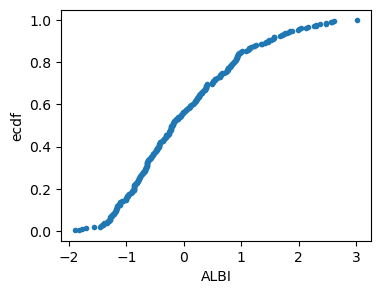

In [58]:
# Getting sense of how ALBI are distributed
x, y = ecdf(part_process_df['ALBI'])
plt.figure(figsize=(4,3))
plt.plot(x,y,marker='.', linestyle='none')
plt.xlabel('ALBI')
plt.ylabel('ecdf');

#### Predicting Advanced Fibrosis<a id='predicting_advanced_fibrosis_albi'></a>

AUC: 0.705


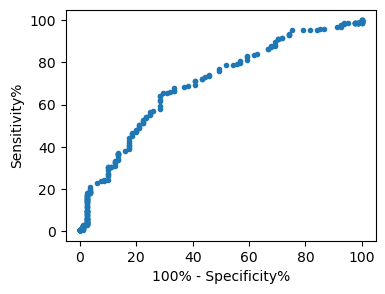

In [68]:
# for differentiating between advanced fibrosis (F3/F4) and non-advanced fibrosis (F1/F2)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    albi_df = preprocess_df[['ALBI']]
    albi_df['Stage'] = preprocess_df.Stage.str.replace('3|4','3/4',regex=True)
    albi_vals = np.linspace(-2,3,251)
    scores = np.empty([251,5])
    true = albi_df['Stage'].values
    for ind, cutoff in enumerate(albi_vals):
        pred = np.array(['1/2' if val < cutoff else '3/4' for val in albi_df['ALBI'].values], dtype='object')
        scores[ind] = calc_class_scores(true, pred)

# note: because the positive case is non-cirrhotic, sensitivity and specificity are reversed
plt.figure(figsize=(4,3))
plt.plot(100-100*scores[:,1], 100*scores[:,0], marker='.', linestyle='none')
plt.xlabel('100% - Specificity%')
plt.ylabel('Sensitivity%')
print('AUC: {:.3f}'.format(np.trapz(scores[:,0], x=scores[:,1]-1)));

In [69]:
# finding the cut-off which corresponds to maximizing the product of sensitivity and specificity
max_ind, max_val = (0, 0)
for ind, val in enumerate(scores[:,1]*scores[:,0]/(scores[:,1]+scores[:,0])):
    if val > max_val:
        max_val = val
        max_ind = ind
print('ALBI cut-off: {:.3f}'.format(albi_vals[max_ind]))
print('sensitivity (predict advanced): {:.3f}'.format(scores[max_ind,0]))
print('specificity (predict non-advanced): {:.3f}'.format(scores[max_ind,1]))
print('accuracy: {:.3f}'.format(scores[max_ind,4]))
print('precision: {:.3f}'.format(scores[max_ind,2]))
print('f1-score: {:.3f}'.format(scores[max_ind,3]))

ALBI cut-off: -0.320
sensitivity (predict advanced): 0.653
specificity (predict non-advanced): 0.704
accuracy: 0.667
precision: 0.860
f1-score: 0.742


In [66]:
# corresponding sensitivity, specificity, and accuracy using the published cut-off value
# remember, the published data trained on Hep C patients
albi_df = preprocess_df[['ALBI', 'Stage']]
albi_df['Stage'] = preprocess_df.Stage.str.replace('3|4','3/4',regex=True)
albi_cutoff = -2.6
pred = np.array(['1/2' if val < cutoff else '3/4' for val in albi_df['ALBI'].values], dtype='object')
true = albi_df['Stage'].values
scores = calc_class_scores(true, pred)

print('ALBI cut-off: {:.3f}'.format(albi_cutoff))
print('sensitivity (predict advanced): {:.3f}'.format(scores[0]))
print('specificity (predict non-advanced): {:.3f}'.format(scores[1]))
print('accuracy: {:.3f}'.format(scores[4]))
print('precision: {:.3f}'.format(scores[2]))
print('f1-score: {:.3f}'.format(scores[3]))

ALBI cut-off: -2.600
sensitivity (predict advanced): 0.004
specificity (predict non-advanced): 1.000
accuracy: 0.268
precision: 1.000
f1-score: 0.009


C:\Users\kimvo\AppData\Local\Temp\ipykernel_8988\56723183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albi_df['Stage'] = preprocess_df.Stage.str.replace('3|4','3/4',regex=True)


#### Predicting Cirrhosis<a id='predicting_cirrhosis_albi'></a>

AUC: -0.723


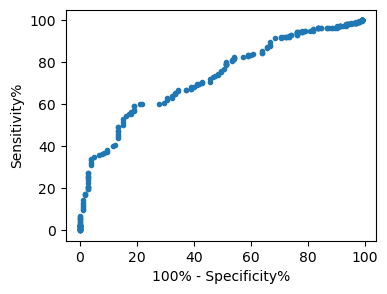

In [71]:
# for differentiating between non-cirrhotic (F1/F2/F3) and cirrhotic (F4)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    albi_df = preprocess_df[['ALBI', 'Stage']]
    albi_df['Stage'] = preprocess_df.Stage.str.replace('1/2|3','1/2/3',regex=True)
    albi_vals = np.linspace(-2,3,251)
    scores = np.empty([251,5])
    true = albi_df['Stage'].values
    for ind, cutoff in enumerate(albi_vals):
        pred = np.array(['1/2/3' if val < cutoff else '4' for val in albi_df['ALBI'].values], dtype='object')
        scores[ind] = calc_class_scores(true, pred)

# note: because the positive case is non-cirrhotic, sensitivity and specificity are reversed
plt.figure(figsize=(4,3))
plt.plot(100-100*scores[:,0], 100*scores[:,1], marker='.', linestyle='none')
plt.xlabel('100% - Specificity%')
plt.ylabel('Sensitivity%')
print('AUC: {:.3f}'.format(np.trapz(scores[:,1], x=scores[:,0]-1)));

In [72]:
# finding the cut-off which corresponds to maximizing the product of sensitivity and specificity
max_ind, max_val = (0, 0)
for ind, val in enumerate(scores[:,0]*scores[:,1]):
    if val > max_val:
        max_val = val
        max_ind = ind
print('ALBI cut-off: {:.3f}'.format(albi_vals[max_ind]))
print('sensitivity (predict cirrhotic): {:.3f}'.format(scores[max_ind,0]))
print('specificity (predict non-cirrhotic): {:.3f}'.format(scores[max_ind,1]))
print('accuracy: {:.3f}'.format(scores[max_ind,4]))
print('precision: {:.3f}'.format(scores[max_ind,2]))
print('f1-score: {:.3f}'.format(scores[max_ind,3]))

ALBI cut-off: -0.300
sensitivity (predict cirrhotic): 0.810
specificity (predict non-cirrhotic): 0.592
accuracy: 0.667
precision: 0.509
f1-score: 0.625


In [38]:
# corresponding sensitivity, specificity, and accuracy using the published cut-off value
# remember, the published data trained on Hep C patients
albi_df = preprocess_df[['ALBI', 'Stage']]
albi_df['Stage'] = preprocess_df.Stage.str.replace('1/2|3','1/2/3',regex=True)
albi_cutoff = -2.125
pred = np.array(['1/2/3' if val < cutoff else '4' for val in albi_df['ALBI'].values], dtype='object')
true = albi_df['Stage'].values
scores = calc_class_scores(true, pred)

print('ALBI cut-off: {:.3f}'.format(albi_cutoff))
print('sensitivity (predict non-cirrhotic): {:.3f}'.format(scores[0]))
print('specificity (predict cirrhotic): {:.3f}'.format(scores[1]))
print('accuracy: {:.3f}'.format(scores[4]))
print('precision: {:.3f}'.format(scores[2]))
print('f1-score: {:.3f}'.format(scores[3]))

ALBI cut-off: -2.125
sensitivity (predict non-cirrhotic): 1.000
specificity (predict cirrhotic): 0.010
accuracy: 0.660
precision: 0.010
f1-score: 0.019


C:\Users\kimvo\AppData\Local\Temp\ipykernel_8988\2838703662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albi_df['Stage'] = preprocess_df.Stage.str.replace('1/2|3','1/2/3',regex=True)


### APRI Model <a id='albi_model'></a>
**Result:**
|              |             | **Advanced Fibrosis (F3)** | **Cirrhosis (F4)** |
|--------------|-------------|------------------------|----------------|
|**APRI Score**| AUC         | 0.673 | 0.660|
|              | Best cutoff | -0.38 | -0.22 |
|              | Sensitivity | 0.649 | 0.638 |
|              | Specificity | 0.654 | 0.657|
|              | Accuracy    | 0.65  | 0.65|
|              | Precision   | 0.849 | 0.493 |
|              | F1-Score    | 0.732 | 0.556 |

In [83]:
part_process_df = partial_process(df)

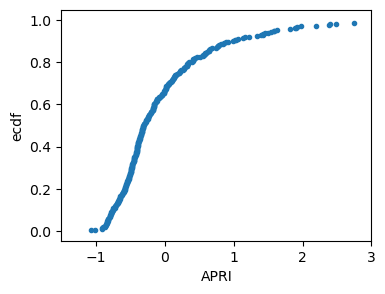

In [84]:
# Getting sense of how APRI is distributed
x, y = ecdf(part_process_df['APRI'])
plt.figure(figsize=(4,3))
plt.plot(x,y,marker='.', linestyle='none')
plt.xlabel('APRI')
plt.ylabel('ecdf')
plt.xlim([-1.5,3]);

#### Predicting Advanced Fibrosis<a id='predicting_advanced_fibrosis_apri'></a>

AUC: 0.673


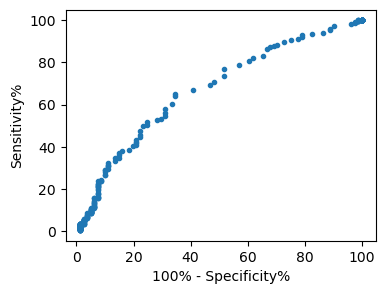

In [78]:
# for differentiating between advanced fibrosis (F3/F4) and non-advanced fibrosis (F1/F2)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    apri_df = preprocess_df[['APRI']]
    apri_df['Stage'] = preprocess_df.Stage.str.replace('3|4','3/4',regex=True)
    apri_vals = np.linspace(-2,4,301)
    scores = np.empty([301,5])
    true = apri_df['Stage'].values
    for ind, cutoff in enumerate(apri_vals):
        pred = np.array(['1/2' if val < cutoff else '3/4' for val in apri_df['APRI'].values], dtype='object')
        scores[ind] = calc_class_scores(true, pred)

# note: because the positive case is non-cirrhotic, sensitivity and specificity are reversed
plt.figure(figsize=(4,3))
plt.plot(100-100*scores[:,1], 100*scores[:,0], marker='.', linestyle='none')
plt.xlabel('100% - Specificity%')
plt.ylabel('Sensitivity%')
print('AUC: {:.3f}'.format(np.trapz(scores[:,0], x=scores[:,1]-1)));

In [75]:
# finding the cut-off which corresponds to maximizing the product of sensitivity and specificity
max_ind, max_val = (0, 0)
for ind, val in enumerate(scores[:,0]*scores[:,1]):
    if val > max_val:
        max_val = val
        max_ind = ind
print('APRI cut-off: {:.3f}'.format(apri_vals[max_ind]))
print('sensitivity (predict advanced): {:.3f}'.format(scores[max_ind,0]))
print('specificity (predict non-advanced): {:.3f}'.format(scores[max_ind,1]))
print('accuracy: {:.3f}'.format(scores[max_ind,4]))
print('precision: {:.3f}'.format(scores[max_ind,2]))
print('f1-score: {:.3f}'.format(scores[max_ind,3]))

APRI cut-off: -0.380
sensitivity (predict advanced): 0.649
specificity (predict non-advanced): 0.654
accuracy: 0.650
precision: 0.839
f1-score: 0.732


In [41]:
# corresponding sensitivity, specificity, and accuracy using the published cut-off value
# remember, the published data trained on Hep C patients
apri_df = preprocess_df[['APRI', 'Stage']]
apri_df['Stage'] = preprocess_df.Stage.str.replace('3|4','3/4',regex=True)
apri_cutoff = -2.6
pred = np.array(['1/2' if val < cutoff else '3/4' for val in apri_df['APRI'].values], dtype='object')
true = apri_df['Stage'].values
scores = calc_class_scores(true, pred)

print('APRI cut-off: {:.3f}'.format(apri_cutoff))
print('sensitivity (predict non-advanced): {:.3f}'.format(scores[0]))
print('specificity (predict advanced): {:.3f}'.format(scores[1]))
print('accuracy: {:.3f}'.format(scores[4]))
print('precision: {:.3f}'.format(scores[2]))
print('f1-score: {:.3f}'.format(scores[3]))

APRI cut-off: -2.600
sensitivity (predict non-advanced): 0.988
specificity (predict advanced): 0.004
accuracy: 0.265
precision: 0.004
f1-score: 0.009


C:\Users\kimvo\AppData\Local\Temp\ipykernel_8988\584939532.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apri_df['Stage'] = preprocess_df.Stage.str.replace('3|4','3/4',regex=True)


#### Predicting Cirrhosis<a id='predicting_cirrhosis_apri'></a>

AUC: 0.660


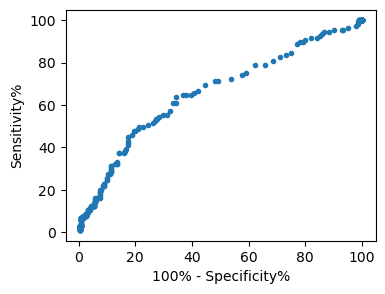

In [79]:
# for differentiating between cirrhosis (F4) and non-cirrhosis (F1/F2/F3)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    apri_df = preprocess_df[['APRI']]
    apri_df['Stage'] = preprocess_df.Stage.str.replace('1/2|3','1/2/3',regex=True)
    apri_vals = np.linspace(-2,4,301)
    scores = np.empty([301,5])
    true = apri_df['Stage'].values
    for ind, cutoff in enumerate(apri_vals):
        pred = np.array(['1/2/3' if val < cutoff else '4' for val in apri_df['APRI'].values], dtype='object')
        scores[ind] = calc_class_scores(true, pred)

# note: because the positive case is non-cirrhotic, sensitivity and specificity are reversed
plt.figure(figsize=(4,3))
plt.plot(100-100*scores[:,1], 100*scores[:,0], marker='.', linestyle='none')
plt.xlabel('100% - Specificity%')
plt.ylabel('Sensitivity%')
print('AUC: {:.3f}'.format(np.trapz(scores[:,0], x=scores[:,1]-1)));

In [80]:
# finding the cut-off which corresponds to maximizing the sum of sensitivity, specificity, and accuracy
max_ind, max_val = (0, 0)
for ind, val in enumerate(scores[:,0]*scores[:,1]):
    if val > max_val:
        max_val = val
        max_ind = ind
print('APRI cut-off: {:.3f}'.format(apri_vals[max_ind]))
print('sensitivity (predict cirrhosis): {:.3f}'.format(scores[max_ind,0]))
print('specificity (predict non-cirrhosis): {:.3f}'.format(scores[max_ind,1]))
print('accuracy: {:.3f}'.format(scores[max_ind,4]))
print('precision: {:.3f}'.format(scores[max_ind,2]))
print('f1-score: {:.3f}'.format(scores[max_ind,3]))

APRI cut-off: -0.220
sensitivity (predict cirrhosis): 0.638
specificity (predict non-cirrhosis): 0.657
accuracy: 0.650
precision: 0.493
f1-score: 0.556


### FIB-4 Model<a id='fib-4_model'></a>
**Result:**
|               |             | **Advanced Fibrosis (F3)** | **Cirrhosis (F4)** |
|---------------|-------------|------------------------|----------------|
|**FIB-4 Score**| AUC         | 0.624 | 0.659|
|               | Best cutoff | -0.24 | -0.16 |
|               | Sensitivity | 0.556 | 0.59 |
|               | Specificity | 0.642 | 0.687|
|               | Accuracy    | 0.578 | 0.654|
|               | Precision   | 0.812 | 0.496|
|               | F1-Score    | 0.660 | 0.539|

In [44]:
part_process_df = partial_process(df)

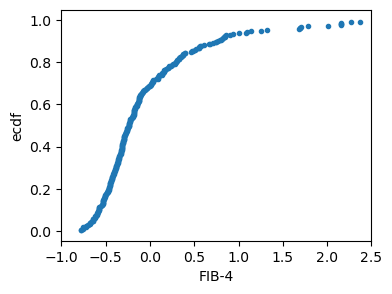

In [45]:
# Getting sense of how fib-4 is distributed
x, y = ecdf(part_process_df['FIB-4'])
plt.figure(figsize=(4,3))
plt.plot(x,y,marker='.', linestyle='none')
plt.xlabel('FIB-4')
plt.ylabel('ecdf')
plt.xlim([-1,2.5]);

#### Predicting Advanced Fibrosis<a id='predicing_advanced_fibrosis_fib-4'></a>

AUC: 0.624


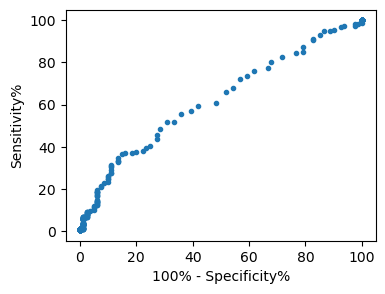

In [81]:
# for differentiating between advanced fibrosis (F3/F4) and non-advanced fibrosis (F1/F2)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fib4_df = preprocess_df[['FIB-4']]
    fib4_df['Stage'] = preprocess_df.Stage.str.replace('3|4','3/4',regex=True)
    fib4_vals = np.linspace(-2,4,301)
    scores = np.empty([301,5])
    true = fib4_df['Stage'].values
    for ind, cutoff in enumerate(fib4_vals):
        pred = np.array(['1/2' if val < cutoff else '3/4' for val in fib4_df['FIB-4'].values], dtype='object')
        scores[ind] = calc_class_scores(true, pred)

# note: because the positive case is non-cirrhotic, sensitivity and specificity are reversed
plt.figure(figsize=(4,3))
plt.plot(100-100*scores[:,1], 100*scores[:,0], marker='.', linestyle='none')
plt.xlabel('100% - Specificity%')
plt.ylabel('Sensitivity%')
print('AUC: {:.3f}'.format(np.trapz(scores[:,0], x=scores[:,1]-1)));

In [82]:
# finding the cut-off which corresponds to maximizing the sum of sensitivity, specificity, and accuracy
max_ind, max_val = (0, 0)
for ind, val in enumerate(scores[:,0]*scores[:,1]):
    if val > max_val:
        max_val = val
        max_ind = ind
print('FIB-4 cut-off: {:.3f}'.format(fib4_vals[max_ind]))
print('sensitivity (predict advanced): {:.3f}'.format(scores[max_ind,0]))
print('specificity (predict non-advanced): {:.3f}'.format(scores[max_ind,1]))
print('accuracy: {:.3f}'.format(scores[max_ind,4]))
print('precision: {:.3f}'.format(scores[max_ind,2]))
print('f1-score: {:.3f}'.format(scores[max_ind,3]))

FIB-4 cut-off: -0.240
sensitivity (predict advanced): 0.556
specificity (predict non-advanced): 0.642
accuracy: 0.578
precision: 0.812
f1-score: 0.660


#### Predicting Cirrhosis<a id='predicting_cirrhosis_fib-3'></a>

AUC: 0.659


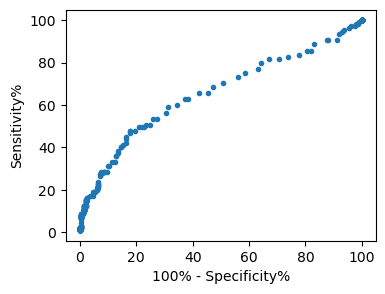

In [83]:
# for differentiating between advanced fibrosis (F3/F4) and non-advanced fibrosis (F1/F2)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fib4_df = preprocess_df[['FIB-4']]
    fib4_df['Stage'] = preprocess_df.Stage.str.replace('1/2|3','1/2/3',regex=True)
    fib4_vals = np.linspace(-2,4,301)
    scores = np.empty([301,5])
    true = fib4_df['Stage'].values
    for ind, cutoff in enumerate(fib4_vals):
        pred = np.array(['1/2/3' if val < cutoff else '4' for val in fib4_df['FIB-4'].values], dtype='object')
        scores[ind] = calc_class_scores(true, pred)

# note: because the positive case is non-cirrhotic, sensitivity and specificity are reversed
plt.figure(figsize=(4,3))
plt.plot(100-100*scores[:,1], 100*scores[:,0], marker='.', linestyle='none')
plt.xlabel('100% - Specificity%')
plt.ylabel('Sensitivity%')
print('AUC: {:.3f}'.format(np.trapz(scores[:,0], x=scores[:,1]-1)));

In [84]:
# finding the cut-off which corresponds to maximizing the sum of sensitivity, specificity, and accuracy
max_ind, max_val = (0, 0)
for ind, val in enumerate(scores[:,0]*scores[:,1]):
    if val > max_val:
        max_val = val
        max_ind = ind
print('FIB-4 cut-off: {:.3f}'.format(fib4_vals[max_ind]))
print('sensitivity (predict cirrhosis): {:.3f}'.format(scores[max_ind,0]))
print('specificity (predict non-cirrhosis): {:.3f}'.format(scores[max_ind,1]))
print('accuracy: {:.3f}'.format(scores[max_ind,4]))
print('precision: {:.3f}'.format(scores[max_ind,2]))
print('f1-score: {:.3f}'.format(scores[max_ind,3]))

FIB-4 cut-off: -0.160
sensitivity (predict cirrhosis): 0.590
specificity (predict non-cirrhosis): 0.687
accuracy: 0.654
precision: 0.496
f1-score: 0.539


## K-Nearest Neighbors<a id='k-nearest_neighbors'></a>
The best parameters for k-NN are ```{'n_neighbors':30, 'weights':'uniform'}``` \
**Result:**
|                |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|----------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**KNN Model**   | **1/2** | 0.511 | 0.725 | 0.478 | 0.482 | 0.717 | 16.48 |
|                | **3**   | 0.487 | 0.619 | 0.488 | 0.482 | 0.590 | 24.32 |
|                | **4**   | 0.593 | 0.747 | 0.647 | 0.609 | 0.746 | 21.20 |

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
X, Y = (preprocess_pca(df.drop(columns='Stage')), df['Stage'].values)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [53]:
knn_class = KNeighborsClassifier()
grid_params = {'n_neighbors':[25, 30, 35, 40],
               'weights':['uniform']}
gridsearch_knn = GridSearchCV(knn_class, grid_params, scoring='f1_micro', return_train_score=True, cv=10)

In [54]:
gridsearch_knn.fit(X, Y)
print(gridsearch_knn.best_estimator_)
print(gridsearch_knn.best_score_)

KNeighborsClassifier(n_neighbors=30)
0.5548387096774194


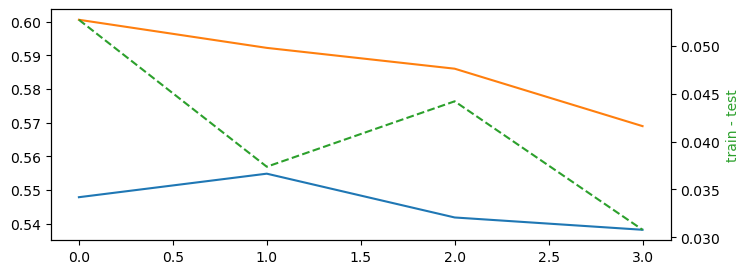

In [55]:
plot_train_test(gridsearch_knn.cv_results_)

In [56]:
list(zip(gridsearch_knn.cv_results_['params'], gridsearch_knn.cv_results_['mean_test_score']))

[({'n_neighbors': 25, 'weights': 'uniform'}, 0.5478494623655914),
 ({'n_neighbors': 30, 'weights': 'uniform'}, 0.5548387096774194),
 ({'n_neighbors': 35, 'weights': 'uniform'}, 0.5418279569892472),
 ({'n_neighbors': 40, 'weights': 'uniform'}, 0.5381720430107526)]

```n_neighbors=30, weights='uniform'``` strikes the best balance between bias and variance

In [57]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bs_knn_results = bs_model(X, Y, KNeighborsClassifier(n_neighbors=30, weights='uniform'), m=10000)
bs_knn_results

recall     specificity       precision        f1-score  \
1/2 mean               0.511           0.725           0.478           0.482   
    95.0% CI  [0.278, 0.769]    [0.56, 0.88]    [0.273, 0.7]  [0.303, 0.647]   
3   mean               0.497           0.619           0.488           0.482   
    95.0% CI  [0.296, 0.714]  [0.421, 0.812]      [0.3, 0.7]  [0.327, 0.625]   
4   mean               0.593           0.747           0.647           0.609   
    95.0% CI   [0.36, 0.826]  [0.571, 0.913]  [0.429, 0.857]  [0.429, 0.762]   

                    accuracy       support  
1/2 mean               0.717        16.478  
    95.0% CI  [0.613, 0.806]  [10.0, 23.0]  
3   mean                0.59        24.325  
    95.0% CI   [0.468, 0.71]  [18.0, 31.0]  
4   mean               0.746        21.197  
    95.0% CI  [0.645, 0.839]  [15.0, 28.0]

## Random Forest<a id='random_forest'></a>
Best params are ```{max_depth=5, n_estimators=175}``` \
**Result:**
|               |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|---------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**RF Model**   | **1/2** | 0.322 | 0.862 | 0.535 | 0.386 | 0.742 | 16.41 |
|               | **3**   | 0.605 | 0.578 | 0.505 | 0.543 | 0.607 | 24.33 |
|               | **4**   | 0.688 | 0.706 | 0.641 | 0.656 | 0.757 | 21.26 |

In [224]:
from sklearn.ensemble import RandomForestClassifier

In [225]:
X, Y = (preprocess_pca(df.drop(columns='Stage')), df['Stage'].values)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [262]:
rf_class = RandomForestClassifier()
grid_params = {'n_estimators':[100, 125, 150, 175, 200], 
               'criterion':['gini'],
               'max_depth':[5]}
gridsearch_rf = GridSearchCV(rf_class, grid_params, scoring='f1_micro', return_train_score=True, cv=5)

In [263]:
gridsearch_rf.fit(x_train, y_train)
print(gridsearch_rf.best_estimator_)
print(gridsearch_rf.best_score_)

RandomForestClassifier(max_depth=5, n_estimators=175)
0.5818027210884353


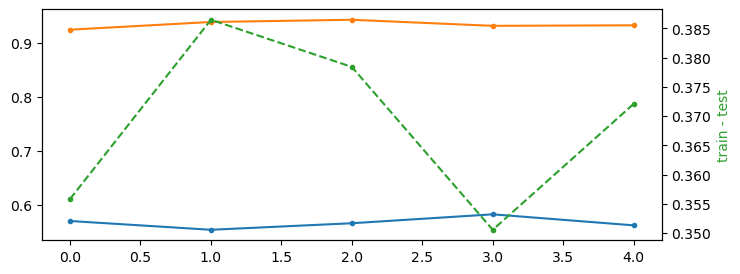

In [264]:
plot_train_test(gridsearch_rf.cv_results_)

In [265]:
list(zip(gridsearch_rf.cv_results_['params'], gridsearch_rf.cv_results_['mean_test_score']))

[({'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100},
  0.5693877551020409),
 ({'criterion': 'gini', 'max_depth': 5, 'n_estimators': 125},
  0.5530612244897959),
 ({'criterion': 'gini', 'max_depth': 5, 'n_estimators': 150},
  0.5652210884353741),
 ({'criterion': 'gini', 'max_depth': 5, 'n_estimators': 175},
  0.5818027210884353),
 ({'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200},
  0.5613095238095238)]

In [266]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bs_rf_results = bs_model(X, Y, RandomForestClassifier(max_depth=5, n_estimators=175), m=10000)
bs_rf_results

recall     specificity      precision        f1-score  \
1/2 mean               0.322           0.862          0.535           0.386   
    95.0% CI  [0.111, 0.583]   [0.73, 0.971]  [0.25, 0.857]  [0.167, 0.588]   
3   mean               0.605           0.578          0.505           0.543   
    95.0% CI    [0.409, 0.8]    [0.4, 0.765]   [0.333, 0.7]  [0.393, 0.677]   
4   mean               0.688           0.706          0.641           0.656   
    95.0% CI  [0.478, 0.889]  [0.533, 0.875]  [0.45, 0.833]    [0.5, 0.789]   

                    accuracy       support  
1/2 mean               0.742        16.407  
    95.0% CI  [0.645, 0.839]  [10.0, 22.0]  
3   mean               0.607        24.331  
    95.0% CI     [0.5, 0.71]  [18.0, 31.0]  
4   mean               0.757        21.262  
    95.0% CI  [0.661, 0.855]  [15.0, 28.0]

**Result:**
|               |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|---------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**RF Model**   | **1/2** | 0.322 | 0.862 | 0.535 | 0.386 | 0.742 | 16.41 |
|               | **3**   | 0.605 | 0.578 | 0.505 | 0.543 | 0.607 | 24.33 |
|               | **4**   | 0.688 | 0.706 | 0.641 | 0.656 | 0.757 | 21.26 |

In [267]:
from sklearn.metrics import confusion_matrix

In [268]:
rf_model = RandomForestClassifier(max_depth=5, n_estimators=175).fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['1/2', '3', '4'], index=['1/2', '3', '4'])

,1/2,3,4
1/2,3,8,1
3,3,15,9
4,2,8,13


## Logistic Regression<a id='logistic_regression'></a>
**Results:**
|                |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|----------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**Log Model**   | **1/2** | 0.430 | 0.787 | 0.499 | 0.447 | 0.728 | 16.42 |
|                | **3**   | 0.515 | 0.628 | 0.496 | 0.497 | 0.600 | 24.33 |
|                | **4**   | 0.683 | 0.710 | 0.649 | 0.659 | 0.762 | 21.25 |

In [46]:
from sklearn.linear_model import LogisticRegression

In [24]:
X, Y = (preprocess_df.drop(columns='Stage').values, df['Stage'].values)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [64]:
log_model = LogisticRegression()
grid_params = {'C':[0.001, 0.003, 0.01, 0.03, 0.1, 0.3]}
gridsearch_log = GridSearchCV(log_model, grid_params, return_train_score=True, scoring='f1_micro')

In [65]:
gridsearch_log.fit(X, Y)
print(gridsearch_log.best_estimator_)
print(gridsearch_log.best_score_)

LogisticRegression(C=0.1)
0.5619249074563722


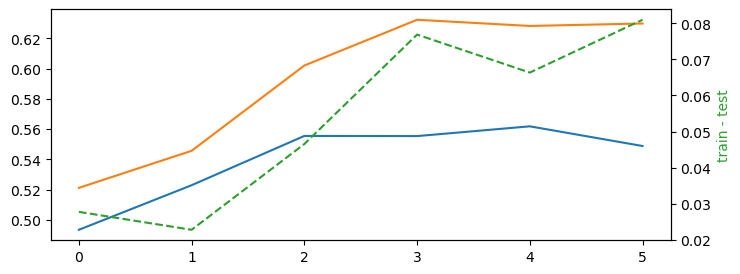

In [66]:
plot_train_test(gridsearch_log.cv_results_)

In [67]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bs_log_results = bs_model(X, Y, LogisticRegression(C=0.1), m=10000)
bs_log_results

recall     specificity       precision       f1-score  \
1/2 mean                0.43           0.787           0.499          0.447   
    95.0% CI    [0.2, 0.687]  [0.622, 0.937]  [0.263, 0.786]  [0.25, 0.625]   
3   mean               0.515           0.628           0.496          0.497   
    95.0% CI   [0.31, 0.737]  [0.447, 0.806]   [0.32, 0.692]  [0.341, 0.64]   
4   mean               0.683            0.71           0.649          0.659   
    95.0% CI  [0.478, 0.875]  [0.536, 0.879]   [0.455, 0.84]   [0.5, 0.792]   

                    accuracy       support  
1/2 mean               0.728        16.422  
    95.0% CI  [0.629, 0.823]  [10.0, 23.0]  
3   mean                 0.6        24.329  
    95.0% CI   [0.484, 0.71]  [18.0, 31.0]  
4   mean               0.762        21.248  
    95.0% CI  [0.661, 0.855]  [15.0, 28.0]

## Naive Bayes<a id='naive_bayes'></a>
**Results:**
|               |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|---------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**NB Model**   | **1/2** | 0.482 | 0.724 | 0.500 | 0.440 | 0.709 | 16.41 |
|               | **3**   | 0.656 | 0.401 | 0.428 | 0.502 | 0.513 | 24.28 |
|               | **4**   | 0.291 | 0.919 | 0.752 | 0.408 | 0.722 | 21.32 |

In [68]:
from sklearn.naive_bayes import GaussianNB

In [69]:
X, Y = (preprocess_df.drop(columns='Stage').values, preprocess_df['Stage'].values)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [98]:
nb_model = GaussianNB()
grid_params = {'var_smoothing':[100, 30, 10, 8, 7, 6, 5, 4, 3, 2, 1, 1e-9]}
gridsearch_nb = GridSearchCV(nb_model, grid_params, scoring='f1_micro', return_train_score=True, cv=10)

In [99]:
gridsearch_nb.fit(x_train, y_train)
print(gridsearch_nb.best_estimator_)
print(gridsearch_nb.best_score_)

GaussianNB(var_smoothing=6)
0.5328333333333333


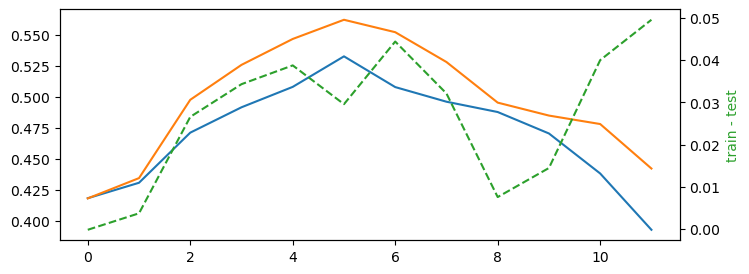

In [100]:
plot_train_test(gridsearch_nb.cv_results_)

In [102]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bs_results = bs_model(X, Y, GaussianNB(var_smoothing=6), m=10000)
bs_results

recall     specificity     precision        f1-score  \
1/2 mean               0.482           0.724           0.5            0.44   
    95.0% CI    [0.0, 0.846]    [0.353, 1.0]    [0.0, 1.0]    [0.0, 0.649]   
3   mean               0.656           0.401         0.428           0.502   
    95.0% CI  [0.261, 0.952]  [0.125, 0.687]  [0.279, 0.6]    [0.3, 0.646]   
4   mean               0.291           0.919         0.752           0.408   
    95.0% CI    [0.1, 0.529]      [0.8, 1.0]  [0.429, 1.0]  [0.167, 0.645]   

                    accuracy       support  
1/2 mean               0.709        16.405  
    95.0% CI  [0.532, 0.839]  [10.0, 23.0]  
3   mean               0.513        24.276  
    95.0% CI  [0.371, 0.645]  [18.0, 31.0]  
4   mean               0.722        21.319  
    95.0% CI  [0.613, 0.823]  [15.0, 28.0]

**Results:**
|               |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|---------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**NB Model**   | **1/2** | 0.482 | 0.724 | 0.500 | 0.440 | 0.709 | 16.41 |
|               | **3**   | 0.656 | 0.401 | 0.428 | 0.502 | 0.513 | 24.28 |
|               | **4**   | 0.291 | 0.919 | 0.752 | 0.408 | 0.722 | 21.32 |

## Support Vector Machine<a id='support_vector_machine'></a>
**Results:**
|                |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|----------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**SVM Model**   | **1/2** | 0.421 | 0.804 | 0.524 | 0.436 | 0.735 | 16.40 |
|                | **3**   | 0.538 | 0.584 | 0.479 | 0.495 | 0.580 | 24.35 |
|                | **4**   | 0.634 | 0.717 | 0.637 | 0.628 | 0.748 | 21.25 |

In [167]:
from sklearn.svm import SVC, NuSVC

In [216]:
X, Y = (preprocess_df.drop(columns='Stage').values, preprocess_df['Stage'].values)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [160]:
svc_model = SVC()
grid_params = {'C':[0.01, 0.03, 0.1, 1, 3, 10],
               'kernel':['sigmoid']}
gridsearch_svc = GridSearchCV(svc_model, grid_params, scoring='f1_micro', return_train_score=True, cv=10)

In [161]:
gridsearch_svc.fit(x_train, y_train)
print(gridsearch_svc.best_estimator_)
print(gridsearch_svc.best_score_)

SVC(C=1, kernel='sigmoid')
0.5783333333333334


0.1, linear, 0.5495
1, sigmoid, 0.586

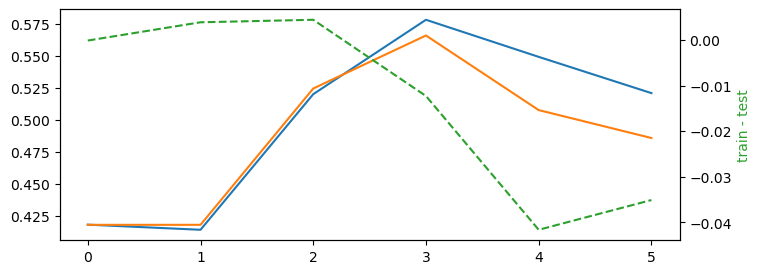

In [162]:
plot_train_test(gridsearch_svc.cv_results_)

In [164]:
list(zip(gridsearch_svc.cv_results_['params'], gridsearch_svc.cv_results_['mean_test_score']))

[({'C': 0.01, 'kernel': 'sigmoid'}, 0.4181666666666667),
 ({'C': 0.03, 'kernel': 'sigmoid'}, 0.4141666666666667),
 ({'C': 0.1, 'kernel': 'sigmoid'}, 0.5201666666666667),
 ({'C': 1, 'kernel': 'sigmoid'}, 0.5783333333333334),
 ({'C': 3, 'kernel': 'sigmoid'}, 0.5493333333333333),
 ({'C': 10, 'kernel': 'sigmoid'}, 0.5209999999999999)]

In [166]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bs_svc_results = bs_model(X, Y, SVC(C=1, kernel='sigmoid'), m=10000)
bs_svc_results

recall     specificity       precision        f1-score  \
1/2 mean               0.421           0.804           0.524           0.436   
    95.0% CI  [0.048, 0.727]    [0.615, 1.0]    [0.231, 1.0]   [0.087, 0.64]   
3   mean               0.538           0.584           0.479           0.495   
    95.0% CI    [0.318, 0.8]  [0.333, 0.786]  [0.304, 0.679]  [0.346, 0.632]   
4   mean               0.634           0.717           0.637           0.628   
    95.0% CI  [0.429, 0.842]   [0.536, 0.88]  [0.444, 0.833]  [0.471, 0.769]   

                    accuracy       support  
1/2 mean               0.735        16.399  
    95.0% CI  [0.629, 0.839]  [10.0, 23.0]  
3   mean                0.58        24.348  
    95.0% CI  [0.452, 0.694]  [18.0, 31.0]  
4   mean               0.748        21.253  
    95.0% CI  [0.645, 0.839]  [15.0, 28.0]

In [219]:
svc_model = SVC(C=1, kernel='sigmoid')
svc_model.fit(x_train, y_train)
y_pred = svc_model.predict(x_test)

In [223]:
pd.DataFrame(calc_3class_scores(y_test, y_pred)).T

,recall,specificity,precision,f1-score,accuracy,support
1/2,0.444444,0.710526,0.266667,0.333333,0.741935,9.0
3,0.440000,0.588235,0.440000,0.440000,0.548387,25.0
4,0.571429,0.714286,0.727273,0.640000,0.709677,28.0


## Gradient Boosting<a id='gradient_boosting'></a>
Having trouble properly tuning hyperparameters. Either the model overfits to the training set immediately or does not train much at all.

**Results:**
|               |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|---------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**GB Model**   | **1/2** | 0.026 | 0.973 | 0.150 | 0.041 | 0.728 | 16.41 |
|               | **3**   | 0.759 | 0.296 | 0.423 | 0.534 | 0.489 | 24.35 |
|               | **4**   | 0.482 | 0.736 | 0.610 | 0.514 | 0.703 | 21.25 |

In [176]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
X, Y = (preprocess_df.drop(columns='Stage').values, preprocess_df['Stage'].values)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [210]:
grid_params = {'learning_rate':[0.01],
               'max_depth':[3],
               'n_estimators':[10, 15, 18, 20, 23, 25, 30]}
gridsearch_gb = GridSearchCV(GradientBoostingClassifier(), grid_params, scoring='f1_micro', return_train_score=True, cv=10)

In [211]:
gridsearch_gb.fit(x_train, y_train)
print(gridsearch_gb.best_estimator_)
print(gridsearch_gb.best_score_)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=20)
0.5123333333333333


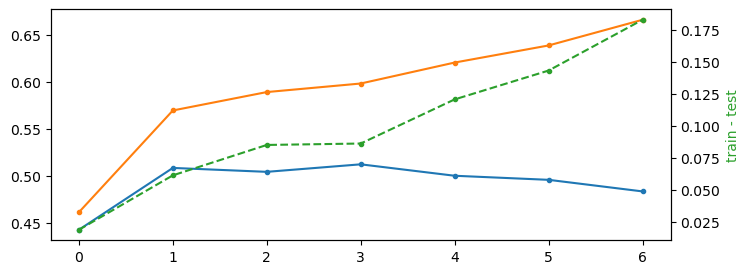

In [213]:
plot_train_test(gridsearch_gb.cv_results_)

In [214]:
list(zip(gridsearch_gb.cv_results_['params'], gridsearch_gb.cv_results_['mean_test_score']))

[({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10},
  0.44266666666666665),
 ({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 15}, 0.5085),
 ({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 18},
  0.5043333333333333),
 ({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20},
  0.5123333333333333),
 ({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 23},
  0.5001666666666666),
 ({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 25},
  0.4958333333333333),
 ({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 30}, 0.4835)]

In [215]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bs_gb_results = bs_model(X, Y, GradientBoostingClassifier(n_estimators=20, learning_rate=0.01), m=10000)
bs_gb_results

recall     specificity       precision        f1-score  \
1/2 mean             0.026           0.973            0.15           0.041   
    95.0% CI  [0.0, 0.182]    [0.853, 1.0]      [0.0, 1.0]     [0.0, 0.25]   
3   mean             0.759           0.296           0.423           0.534   
    95.0% CI  [0.5, 0.958]  [0.121, 0.515]  [0.293, 0.571]  [0.414, 0.648]   
4   mean             0.482           0.736            0.61           0.514   
    95.0% CI  [0.2, 0.789]  [0.483, 0.955]     [0.36, 0.9]  [0.294, 0.683]   

                    accuracy       support  
1/2 mean               0.728        16.405  
    95.0% CI  [0.629, 0.823]  [10.0, 23.0]  
3   mean               0.489         24.35  
    95.0% CI  [0.355, 0.613]  [18.0, 31.0]  
4   mean               0.703        21.245  
    95.0% CI  [0.597, 0.806]  [15.0, 28.0]

**Results:**
|               |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** |**support** |
|---------------|---------|-----------------|-----------------|---------------|--------------|--------------|------------|
|**GB Model**   | **1/2** | 0.026 | 0.973 | 0.150 | 0.041 | 0.728 | 16.41 |
|               | **3**   | 0.759 | 0.296 | 0.423 | 0.534 | 0.489 | 24.35 |
|               | **4**   | 0.482 | 0.736 | 0.610 | 0.514 | 0.703 | 21.25 |

## Feedforward NN<a id='feedforward_nn'></a>
Two models were tested, one for detecting advanced fibrosis (F3/F4) and the other for detecting cirrhosis (F4). 

**Results:**
|                |         | **sensitivity** | **specificity** | **precision** | **f1-score** | **accuracy** | **support pos** |**support neg** |
|----------------|---------|-----------------|-----------------|---------------|--------------|--------------|-----------------|----------------|
|**FNN Model**   | **1/2** | 0.357 | 0.938 | 0.802 | 0.863 | 0.784 | 16.46 | 45.54 |
|                | **4**   | 0.510 | 0.909 | 0.694 | 0.837 | 0.771 | 21.44 | 40.56 |

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Softmax

In [18]:
def plot_history(history):
    plt.figure(figsize=(12, 3))
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc=2)

### Predicting Advanced Fibrosis<a id='predicting_advanced_fibrosis_fnn'></a>

In [221]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Softmax

In [222]:
X, Y = (preprocess_df.drop(columns='Stage').values, preprocess_df['Stage'].values.reshape(-1,1))
mapper = {'4':0,'3':0,'1/2':1}
y_binary = np.array([mapper[val] for val in Y.flatten()]).reshape(-1,1)
ohe = OneHotEncoder(sparse_output=False)
y_ohe = ohe.fit_transform(y_binary)

In [223]:
m = 100
scores = np.empty([m, 7])
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
for i in range(m):
    x_train, x_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2)
    
    inputs = keras.Input(shape=(22,))
    x = Dense(8, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    x = Dense(4, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation='sigmoid')(x)
    outputs = keras.layers.Softmax()(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='fnn_cirrhosis')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=100, batch_size=95, validation_split=0.2, verbose=0, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    
    true, pred = (np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1))
    scores[i] = list(calc_2class_scores(true, pred).values())

2/2 [==============================] - 0s 19ms/step


In [224]:
pd.DataFrame(np.mean(scores, axis=0).reshape(1, -1), columns=['recall', 'specificity', 'precision', 'f1-score', 'accuracy', 'support_pos', 'support_neg'])

,recall,specificity,precision,f1-score,accuracy,support_pos,support_neg
0,0.93857,0.35663,0.8015,0.86335,0.78432,45.54,16.46


### Predicting Cirrhosis<a id='predicting_cirrhosis_fnn'></a>

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Softmax

In [79]:
X, Y = (preprocess_df.drop(columns='Stage').values, preprocess_df['Stage'].values.reshape(-1,1))
mapper = {'4':1,'3':0,'1/2':0}
y_binary = np.array([mapper[val] for val in Y.flatten()]).reshape(-1,1)
ohe = OneHotEncoder(sparse_output=False)
y_ohe = ohe.fit_transform(y_binary)

In [177]:
x_train, x_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2)

In [178]:
# testing hyperparameters
inputs = keras.Input(shape=(22,))
x = Dense(8, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = Dense(4, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(2, activation='sigmoid')(x)
outputs = keras.layers.Softmax()(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='fnn_cirrhosis')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [179]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

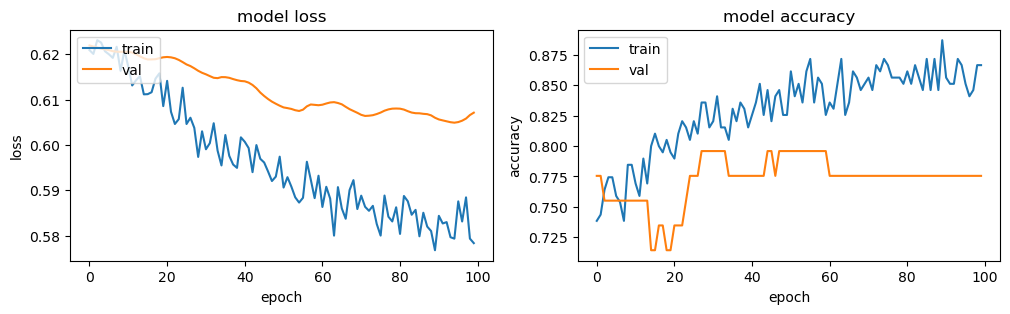

In [188]:
history = model.fit(x_train, y_train, epochs=100, batch_size=95, validation_split=0.2, verbose=0, callbacks=[model_checkpoint_callback])
plot_history(history)

In [189]:
print(model.weights[0][0])
model.load_weights(checkpoint_filepath)
print(model.weights[0][0])

tf.Tensor(
[-0.8397424   0.3727979  -0.03976616  0.14646147 -0.91462773  0.13754845
  0.12588353 -0.29464507], shape=(8,), dtype=float32)
tf.Tensor(
[-0.69090426  0.37417644  0.00825266  0.07205034 -0.7820904   0.03420365
  0.04936866 -0.20504554], shape=(8,), dtype=float32)


In [190]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 11ms/step - loss: 0.6476 - accuracy: 0.7258


[0.6475799679756165, 0.725806474685669]

In [191]:
true, pred = (np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1))
pd.DataFrame([calc_2class_scores(true, pred)])

2/2 [==============================] - 0s 4ms/step


,recall,specificity,precision,f1-score,accuracy,support_pos,support_neg
0,0.944,0.423,0.694,0.8,0.726,36,26


In [204]:
# architecture chosen and now re-testing 100 times to get a better sense of model performance
m = 100
scores = np.empty([m, 7])
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
for i in range(m):
    x_train, x_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2)
    
    inputs = keras.Input(shape=(22,))
    x = Dense(8, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    x = Dense(4, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation='sigmoid')(x)
    outputs = keras.layers.Softmax()(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='fnn_cirrhosis')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=100, batch_size=95, validation_split=0.2, verbose=0, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    
    true, pred = (np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1))
    scores[i] = list(calc_2class_scores(true, pred).values())

2/2 [==============================] - 0s 0s/step


In [220]:
pd.DataFrame(np.mean(scores, axis=0).reshape(1, -1), columns=['recall', 'specificity', 'precision', 'f1-score', 'accuracy', 'support_pos', 'support_neg'])

,recall,specificity,precision,f1-score,accuracy,support_pos,support_neg
0,0.90862,0.51044,0.779,0.83673,0.77093,40.56,21.44
